## Data Profiling

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from dateutil import parser  # for parse_date_safe

# 1) Load your CSV (change path as needed)
df = pd.read_csv("../data/raw_analyst_ratings.csv")


# Optional: nicer display
pd.set_option("display.max_columns", None)
plt.rcParams["figure.figsize"] = (10, 4)

df.head()

,Unnamed: 0,headline,url,publisher,date,stock
0,0,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,2020-06-05 10:30:54-04:00,A
1,1,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,2020-06-03 10:45:20-04:00,A
2,2,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,2020-05-26 04:30:07-04:00,A
3,3,46 Stocks Moving In Friday's Mid-Day Session,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,2020-05-22 12:45:06-04:00,A
4,4,B of A Securities Maintains Neutral on Agilent...,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,2020-05-22 11:38:59-04:00,A


In [5]:
def parse_date_safe(x):
    """
    Safely parse a date string into a pandas Timestamp.
    Returns NaT if parsing fails.
    """
    x = str(x).strip()
    
    # 1. Try general parser (handles ISO + timezone)
    try:
        return parser.parse(x)
    except Exception:
        pass
    
    # 2. Try explicit US format with time (e.g. 05/22/2020 11:23)
    try:
        return pd.to_datetime(x, format="%m/%d/%Y %H:%M")
    except Exception:
        pass
    
    # 3. Try US format without time (e.g. 05/22/2020)
    try:
        return pd.to_datetime(x, format="%m/%d/%Y")
    except Exception:
        pass
    
    # If everything fails:
    return pd.NaT

# Apply the parser
df["date"] = df["date"].apply(parse_date_safe)

# If the dtype is timezone-aware, drop the timezone
if pd.api.types.is_datetime64tz_dtype(df["date"]):
    df["date"] = df["date"].dt.tz_localize(None)

df["date"].head()


C:\Users\filimon.hailemariam\AppData\Local\Temp\ipykernel_33464\930441296.py:33: DeprecationWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if pd.api.types.is_datetime64tz_dtype(df["date"]):


0    2020-06-05 10:30:54-04:00
1    2020-06-03 10:45:20-04:00
2    2020-05-26 04:30:07-04:00
3    2020-05-22 12:45:06-04:00
4    2020-05-22 11:38:59-04:00
Name: date, dtype: object

In [6]:
# Ensure the 'date' column is converted to datetimes and made timezone-naive
df['date'] = pd.to_datetime(df['date'], errors='coerce', utc=True)
if pd.api.types.is_datetime64tz_dtype(df['date']):
	df['date'] = df['date'].dt.tz_localize(None)

print("Start date:", df['date'].min())
print("End date:", df['date'].max())

Start date: 2009-02-14 00:00:00
End date: 2020-06-11 21:12:35


C:\Users\filimon.hailemariam\AppData\Local\Temp\ipykernel_33464\2400426716.py:3: DeprecationWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if pd.api.types.is_datetime64tz_dtype(df['date']):


In [7]:
# 1) Headline length (characters)
df["headline_len"] = df["headline"].astype(str).str.len()

# 2) Date-only (no time) for daily counts
df["date_only"] = df["date"].dt.date

# 3) Day name (Monday, Tuesday, etc.)
df["weekday"] = df["date"].dt.day_name()

df[["headline", "headline_len", "date", "date_only", "weekday"]].head()


,headline,headline_len,date,date_only,weekday
0,Stocks That Hit 52-Week Highs On Friday,39,2020-06-05 14:30:54,2020-06-05,Friday
1,Stocks That Hit 52-Week Highs On Wednesday,42,2020-06-03 14:45:20,2020-06-03,Wednesday
2,71 Biggest Movers From Friday,29,2020-05-26 08:30:07,2020-05-26,Tuesday
3,46 Stocks Moving In Friday's Mid-Day Session,44,2020-05-22 16:45:06,2020-05-22,Friday
4,B of A Securities Maintains Neutral on Agilent...,87,2020-05-22 15:38:59,2020-05-22,Friday


## EDA 

Headline length statistics

In [8]:
headline_stats = df["headline_len"].describe()
headline_stats


count    1.407328e+06
mean     7.312051e+01
std      4.073531e+01
min      3.000000e+00
25%      4.700000e+01
50%      6.400000e+01
75%      8.700000e+01
max      5.120000e+02
Name: headline_len, dtype: float64

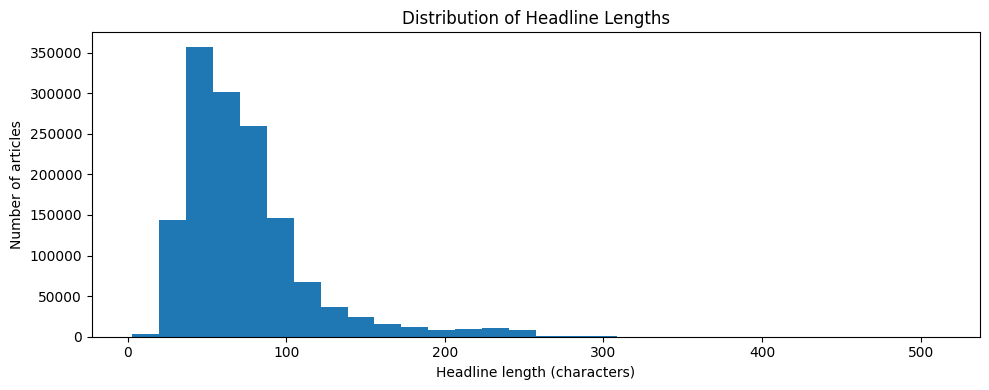

In [9]:
plt.figure()
plt.hist(df["headline_len"], bins=30)
plt.xlabel("Headline length (characters)")
plt.ylabel("Number of articles")
plt.title("Distribution of Headline Lengths")
plt.tight_layout()
plt.show()


Number of articles per publisher

Counts per publisher

In [10]:
publisher_counts = df["publisher"].value_counts()
publisher_counts.head(10)


publisher
Paul Quintaro        228373
Lisa Levin           186979
Benzinga Newsdesk    150484
Charles Gross         96732
Monica Gerson         82380
Eddie Staley          57254
Hal Lindon            49047
ETF Professor         28489
Juan Lopez            28438
Benzinga Staff        28114
Name: count, dtype: int64

Bar chart of most active publishers

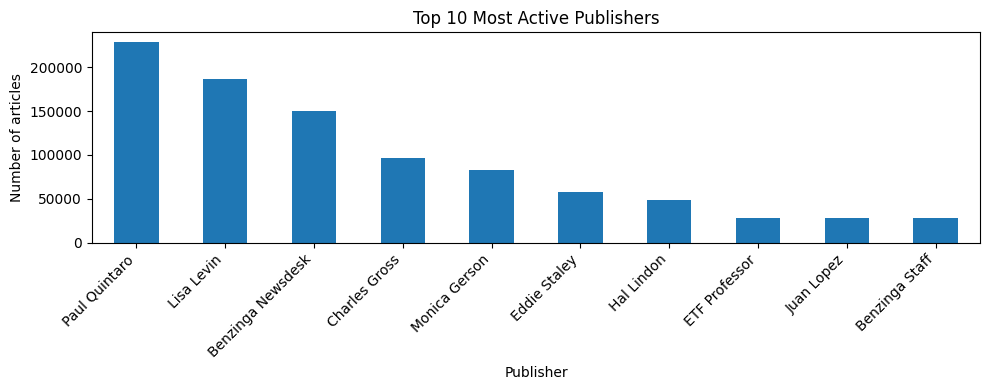

In [11]:
top_n = 10  # change if you want more/less
plt.figure()
publisher_counts.head(top_n).plot(kind="bar")
plt.xlabel("Publisher")
plt.ylabel("Number of articles")
plt.title(f"Top {top_n} Most Active Publishers")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


Publication dates – trends over time

In [ ]:
articles_per_day = df.groupby("date_only").size()

articles_per_day.head()



date_only
2009-02-14    1
2009-04-27    2
2009-04-29    1
2009-05-22    1
2009-05-27    6
dtype: int64

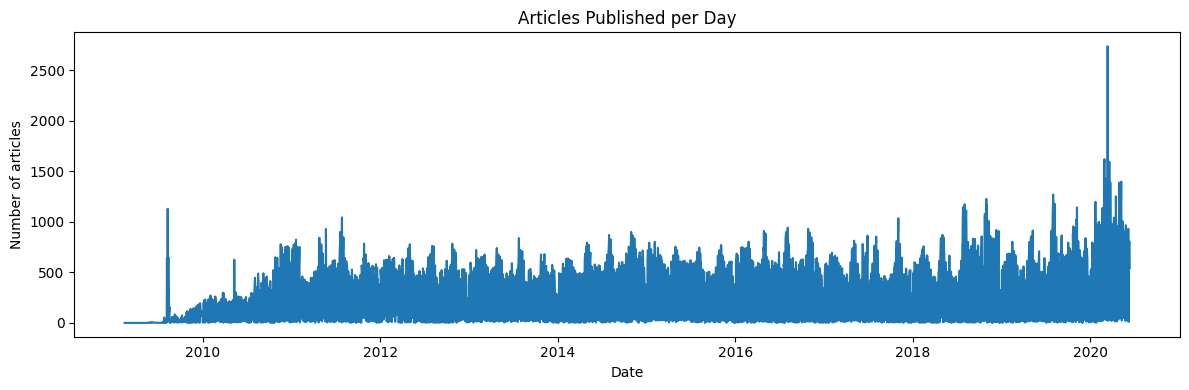

In [13]:
plt.figure(figsize=(12, 4))
articles_per_day.plot()
plt.xlabel("Date")
plt.ylabel("Number of articles")
plt.title("Articles Published per Day")
plt.tight_layout()
plt.show()


Articles by weekday

In [14]:
weekday_counts = (
    df["weekday"]
    .value_counts()
    .reindex(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
)

weekday_counts


weekday
Monday       265139
Tuesday      296505
Wednesday    300922
Thursday     302619
Friday       217918
Saturday       7759
Sunday        16466
Name: count, dtype: int64

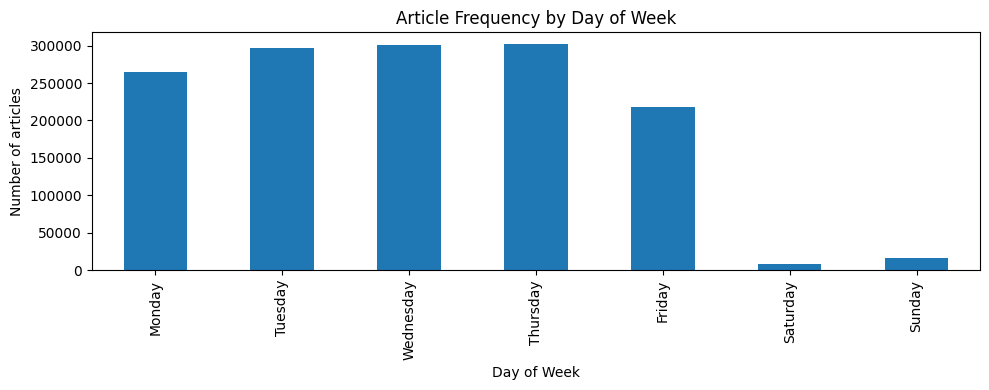

In [15]:
plt.figure()
weekday_counts.plot(kind="bar")
plt.xlabel("Day of Week")
plt.ylabel("Number of articles")
plt.title("Article Frequency by Day of Week")
plt.tight_layout()
plt.show()


Imports for text analysis

In [16]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import numpy as np


basic text cleaning helper

In [17]:
def preprocess_headline(text: str) -> str:
    """
    Very simple preprocessing:
    - lowercase
    - remove extra spaces
    """
    if pd.isna(text):
        return ""
    text = str(text).lower().strip()
    return text

df["headline_clean"] = df["headline"].apply(preprocess_headline)
df[["headline", "headline_clean"]].head()


,headline,headline_clean
0,Stocks That Hit 52-Week Highs On Friday,stocks that hit 52-week highs on friday
1,Stocks That Hit 52-Week Highs On Wednesday,stocks that hit 52-week highs on wednesday
2,71 Biggest Movers From Friday,71 biggest movers from friday
3,46 Stocks Moving In Friday's Mid-Day Session,46 stocks moving in friday's mid-day session
4,B of A Securities Maintains Neutral on Agilent...,b of a securities maintains neutral on agilent...


Most common keywords (unigrams)

In [18]:
# Use CountVectorizer to get word frequencies
vectorizer_uni = CountVectorizer(
    stop_words="english",   # remove common English stopwords
    max_df=0.9,             # ignore words that appear in >90% of documents
    min_df=5                # only keep words that appear in at least 5 headlines (tune this)
)

X_uni = vectorizer_uni.fit_transform(df["headline_clean"])
word_counts = np.array(X_uni.sum(axis=0)).flatten()
vocab = np.array(vectorizer_uni.get_feature_names_out())

# Put into DataFrame for easy viewing
keyword_freq = (
    pd.DataFrame({"keyword": vocab, "count": word_counts})
    .sort_values("count", ascending=False)
    .reset_index(drop=True)
)

keyword_freq.head(20)


,keyword,count
0,vs,162099
1,stocks,161776
2,est,140604
3,eps,128897
4,market,120558
5,shares,114313
6,reports,108710
7,update,91723
8,earnings,87399
9,sales,79645


Most common phrases

In [19]:
vectorizer_bi = CountVectorizer(
    stop_words="english",
    ngram_range=(2, 2),     # bigrams
    max_df=0.9,
    min_df=3
)

X_bi = vectorizer_bi.fit_transform(df["headline_clean"])
bigram_counts = np.array(X_bi.sum(axis=0)).flatten()
bigrams = np.array(vectorizer_bi.get_feature_names_out())

bigram_freq = (
    pd.DataFrame({"bigram": bigrams, "count": bigram_counts})
    .sort_values("count", ascending=False)
    .reset_index(drop=True)
)

bigram_freq.head(20)


,bigram,count
0,52 week,51006
1,price target,47274
2,stocks moving,40044
3,mid day,37324
4,market update,33101
5,earnings scheduled,32055
6,initiates coverage,28993
7,pre market,28393
8,raises pt,27213
9,companies trading,23170


Simple Topic Modeling with LDA

In [25]:

# 1) Sample 100k headlines (or all if you have fewer)
df_sample = df.sample(n=100000, random_state=42)  # adjust n if needed

# 2) Vectorizer: unigrams only, with some basic filtering
vectorizer_topics = CountVectorizer(
    stop_words="english",
    ngram_range=(1, 2),   # <-- unigrams only
    max_df=0.9,
    min_df=5
)

X_topics = vectorizer_topics.fit_transform(df_sample["headline_clean"])

# 3) LDA with ONLINE learning
n_topics = 5  # you can tune this (e.g., 5–10)
lda = LatentDirichletAllocation(
    n_components=n_topics,
    learning_method="online",  # <-- online instead of batch
    max_iter=10,               # a few passes over the data
    random_state=42
)

lda.fit(X_topics)

# 4) Get feature names and print topics (reuse your same function)
feature_names = vectorizer_topics.get_feature_names_out()

def print_topics(model, feature_names, n_top_words=10):
    for topic_idx, topic in enumerate(model.components_):
        top_indices = topic.argsort()[:-n_top_words - 1:-1]
        top_words = [feature_names[i] for i in top_indices]
        print(f"Topic #{topic_idx + 1}: {', '.join(top_words)}")

print_topics(lda, feature_names)


Topic #1: pt, buy, raises, target, maintains, price, 00, price target, announces, downgrades
Topic #2: market, stocks, mid, session, day, shares, moving, stocks moving, mid day, pre
Topic #3: vs, est, eps, reports, sales, trading, shares, q4, estimate, q1
Topic #4: benzinga, stock, update, market, markets, watch, shares, announces, downgrades, upgrades
Topic #5: stocks, week, earnings, 52, 52 week, new, says, scheduled, earnings scheduled, yesterday


In [26]:
df["date_only"] = df["date"].dt.date
df["weekday"] = df["date"].dt.day_name()
df["hour"] = df["date"].dt.hour


Publication frequency over time

In [27]:
# Group by date_only
articles_per_day = df.groupby("date_only").size().rename("article_count")

articles_per_day.head()


date_only
2009-02-14    1
2009-04-27    2
2009-04-29    1
2009-05-22    1
2009-05-27    6
Name: article_count, dtype: int64

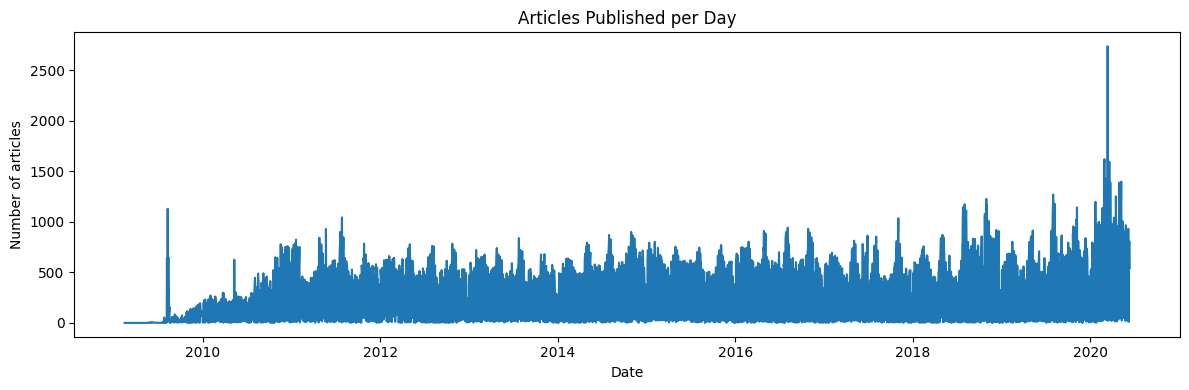

In [28]:
plt.figure(figsize=(12, 4))
articles_per_day.plot()
plt.xlabel("Date")
plt.ylabel("Number of articles")
plt.title("Articles Published per Day")
plt.tight_layout()
plt.show()


smooth with rolling average (7-day)

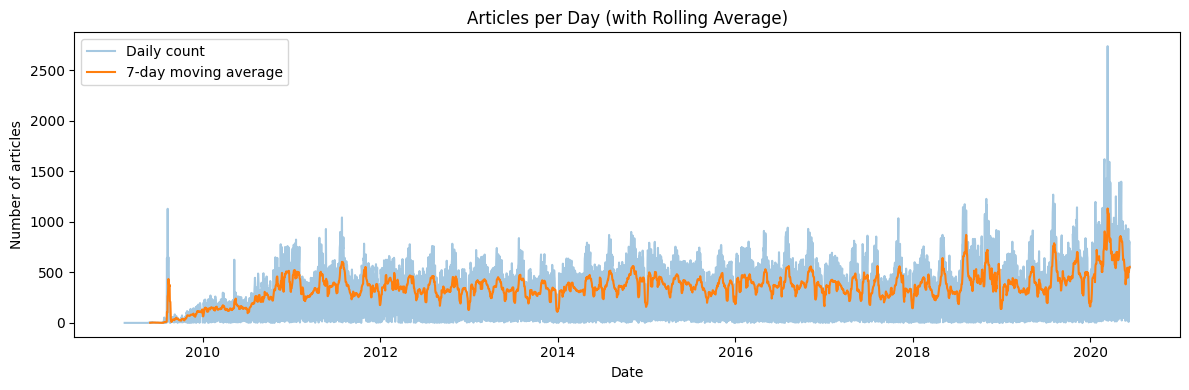

In [29]:
rolling_window = 7
articles_per_day_rolling = articles_per_day.rolling(window=rolling_window).mean()

plt.figure(figsize=(12, 4))
plt.plot(articles_per_day.index, articles_per_day, alpha=0.4, label="Daily count")
plt.plot(articles_per_day_rolling.index, articles_per_day_rolling, label=f"{rolling_window}-day moving average")
plt.xlabel("Date")
plt.ylabel("Number of articles")
plt.title("Articles per Day (with Rolling Average)")
plt.legend()
plt.tight_layout()
plt.show()


Publishing times – When is news released?

Distribution of publishing hours (table)

In [30]:
hour_counts = df["hour"].value_counts().sort_index()
hour_counts


hour
0     1351472
1          82
2          48
3          27
4          67
5          14
6          57
7          93
8        1469
9        1829
10       2476
11       5033
12       5527
13       5965
14       7669
15       5701
16       5732
17       2710
18       2075
19       1612
20       3939
21       2800
22        704
23        227
Name: count, dtype: int64

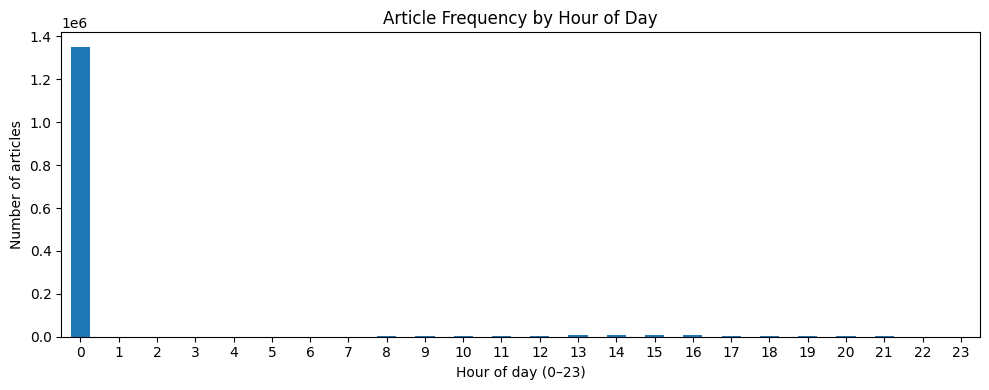

In [31]:
plt.figure(figsize=(10, 4))
hour_counts.plot(kind="bar")
plt.xlabel("Hour of day (0–23)")
plt.ylabel("Number of articles")
plt.title("Article Frequency by Hour of Day")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


Hour-of-day by weekday

In [33]:
hour_weekday = (
    df.groupby(["weekday", "hour"])
      .size()
      .reset_index(name="count")
)

hour_weekday.head(20)


,weekday,hour,count
0,Friday,0,208528
1,Friday,1,9
2,Friday,2,9
3,Friday,3,2
4,Friday,4,16
5,Friday,5,2
6,Friday,6,11
7,Friday,7,14
8,Friday,8,233
9,Friday,9,348


In [34]:
hour_weekday_pivot = hour_weekday.pivot(index="hour", columns="weekday", values="count").fillna(0)
hour_weekday_pivot


weekday,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
hour,,,,,,,
0,208528.0,254866.0,7491.0,16080.0,289937.0,285498.0,289072.0
1,9.0,18.0,4.0,2.0,16.0,22.0,11.0
2,9.0,6.0,2.0,1.0,9.0,18.0,3.0
3,2.0,5.0,0.0,0.0,6.0,8.0,6.0
4,16.0,2.0,1.0,0.0,10.0,7.0,31.0
5,2.0,5.0,0.0,0.0,2.0,2.0,3.0
6,11.0,8.0,0.0,0.0,9.0,11.0,18.0
7,14.0,20.0,0.0,0.0,12.0,24.0,23.0
8,233.0,276.0,0.0,0.0,273.0,348.0,339.0


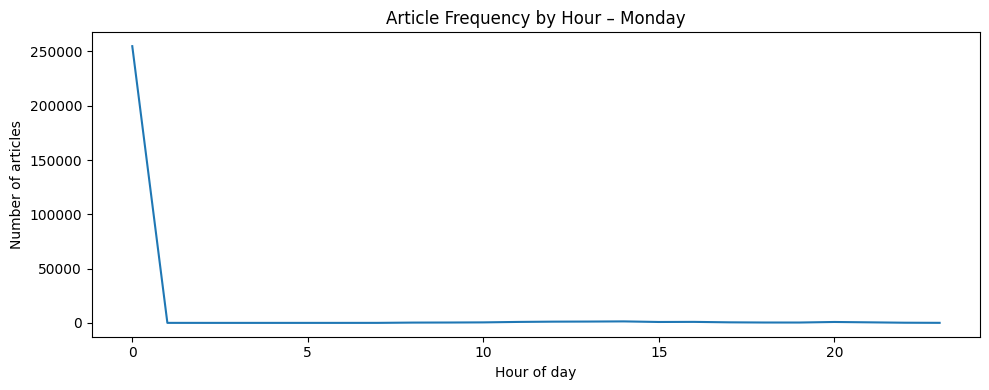

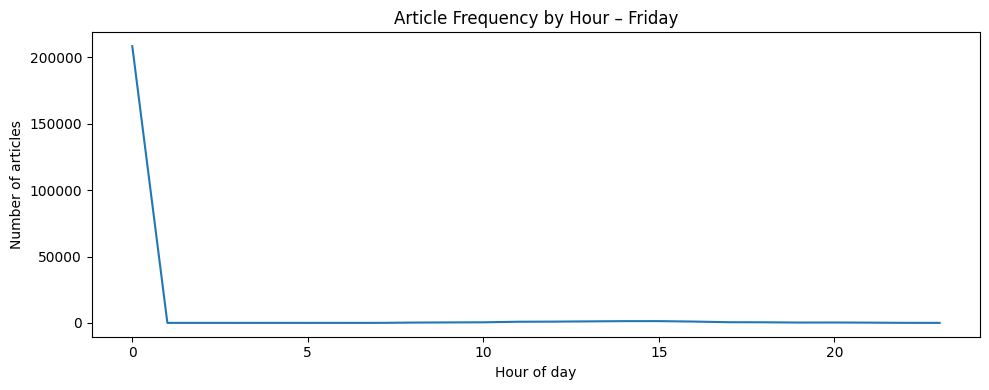

In [35]:
# Example: Monday vs Friday
for day in ["Monday", "Friday"]:
    if day in hour_weekday_pivot.columns:
        plt.figure(figsize=(10, 4))
        plt.plot(hour_weekday_pivot.index, hour_weekday_pivot[day])
        plt.xlabel("Hour of day")
        plt.ylabel("Number of articles")
        plt.title(f"Article Frequency by Hour – {day}")
        plt.tight_layout()
        plt.show()


Publisher Anayalsis

Clean publisher column & extract domains

In [36]:


# Ensure publisher is string
df["publisher"] = df["publisher"].astype(str).str.strip()

# Optional: a lowercased version for grouping
df["publisher_clean"] = df["publisher"].str.lower().str.strip()

# Extract email domain if publisher is an email (e.g. someone@benzinga.com)
df["publisher_domain"] = (
    df["publisher"]
    .str.extract(r'@(.+)$')[0]      # text after '@'
    .fillna("no_domain")           # non-email publishers
)

df[["publisher", "publisher_clean", "publisher_domain"]].head()


,publisher,publisher_clean,publisher_domain
0,Benzinga Insights,benzinga insights,no_domain
1,Benzinga Insights,benzinga insights,no_domain
2,Lisa Levin,lisa levin,no_domain
3,Lisa Levin,lisa levin,no_domain
4,Vick Meyer,vick meyer,no_domain


Counts per publisher

In [37]:
publisher_counts = df["publisher_clean"].value_counts()

publisher_counts.head(10)


publisher_clean
paul quintaro        228373
lisa levin           186979
benzinga newsdesk    150484
charles gross         96732
monica gerson         82380
eddie staley          57254
hal lindon            49047
etf professor         28489
juan lopez            28438
benzinga staff        28114
Name: count, dtype: int64

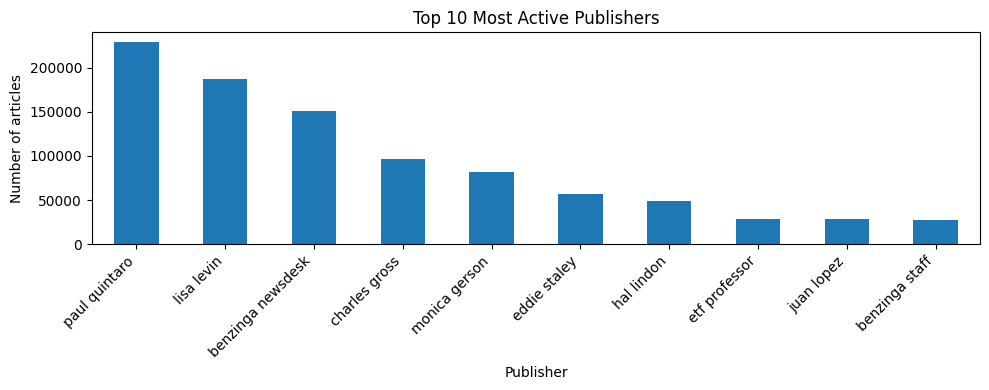

In [38]:
top_n = 10  # change if needed

plt.figure(figsize=(10, 4))
publisher_counts.head(top_n).plot(kind="bar")
plt.xlabel("Publisher")
plt.ylabel("Number of articles")
plt.title(f"Top {top_n} Most Active Publishers")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


In [39]:
from sklearn.feature_extraction.text import CountVectorizer
def top_keywords_for_publisher(df, publisher_name, n_words=10):
    """
    Show top keywords for a given publisher (by publisher_clean).
    """
    subset = df[df["publisher_clean"] == publisher_name]
    texts = subset["headline"].astype(str).str.lower()
    
    if texts.empty:
        print(f"No headlines found for publisher: {publisher_name}")
        return
    
    vectorizer = CountVectorizer(
        stop_words="english",
        max_df=0.9,
        min_df=2  # only keep words appearing in at least 2 headlines
    )
    X = vectorizer.fit_transform(texts)
    word_counts = np.array(X.sum(axis=0)).flatten()
    vocab = np.array(vectorizer.get_feature_names_out())
    
    keyword_freq = (
        pd.DataFrame({"keyword": vocab, "count": word_counts})
        .sort_values("count", ascending=False)
        .reset_index(drop=True)
    )
    
    print(f"\nTop keywords for publisher: {publisher_name}")
    display(keyword_freq.head(n_words))


In [40]:
top_publishers = publisher_counts.head(3).index.tolist()
top_publishers


['paul quintaro', 'lisa levin', 'benzinga newsdesk']

In [41]:
for pub in top_publishers:
    top_keywords_for_publisher(df, pub, n_words=10)



Top keywords for publisher: paul quintaro


,keyword,count
0,vs,86110
1,est,82574
2,eps,57024
3,reports,55267
4,sales,31448
5,shares,22836
6,sees,20735
7,announces,20379
8,00,18419
9,pt,15395



Top keywords for publisher: lisa levin


,keyword,count
0,stocks,68373
1,market,50876
2,mid,42690
3,session,32324
4,moving,32324
5,biggest,29090
6,benzinga,28547
7,day,28211
8,52,26175
9,week,25340



Top keywords for publisher: benzinga newsdesk


,keyword,count
0,shares,42673
1,trading,38841
2,estimate,29404
3,stocks,27844
4,eps,27425
5,sales,27385
6,companies,22019
7,new,21465
8,week,19759
9,higher,19071


Email-based publishers – which domains are most active?

Count domains

In [43]:
domain_counts = df["publisher_domain"].value_counts()

domain_counts.head(10)



publisher_domain
no_domain                 1399240
benzinga.com                 7937
gmail.com                     139
andyswan.com                    5
investdiva.com                  2
tothetick.com                   2
eosdetroit.io                   1
forextraininggroup.com          1
stockmetrix.net                 1
Name: count, dtype: int64

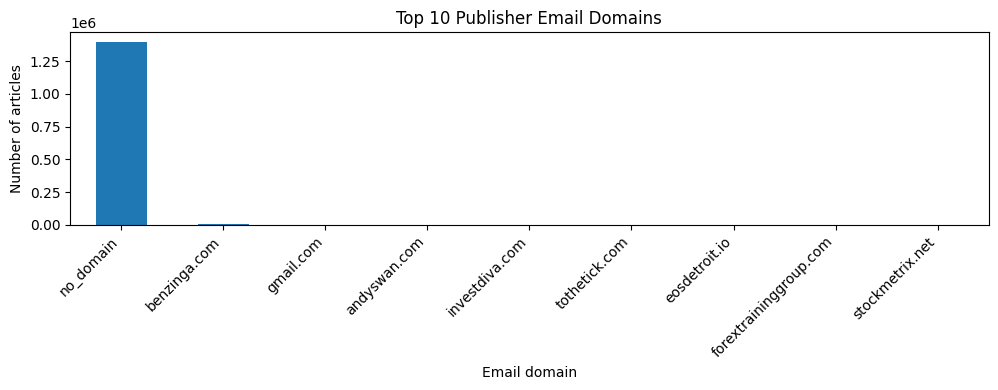

In [44]:
top_n_domains = 10

plt.figure(figsize=(10, 4))
domain_counts.head(top_n_domains).plot(kind="bar")
plt.xlabel("Email domain")
plt.ylabel("Number of articles")
plt.title(f"Top {top_n_domains} Publisher Email Domains")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()